In [1]:
seed = 31

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.simplefilter(action = 'ignore', category = Warning)

import numpy as np
from collections import Counter
np.random.seed(seed)

import logging

import random
random.seed(seed)

#tf.keras.mixed_precision.set_global_policy('mixed_float16')
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

#tf.keras.mixed_precision.set_global_policy('mixed_float16')

import keras
from keras.layers import Activation
from keras.utils import get_custom_objects
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
import time
import os

import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm

2.17.1


In [3]:
# prompt: connect to gdrive
try:
    from google.colab import drive
    drive.mount('/content/drive')
    path = "/content/drive/MyDrive/Data_Bandits_CS418/data/"
    weather_corn_scaled = pd.read_csv(path+"cleaned_data/nn_preprocessed.csv")
    weather_corn_filled = pd.read_csv(path+"cleaned_data/nn_preprocessed_filled.csv")
except:
    path = "../data/"
    weather_corn_scaled = pd.read_csv(path+"crop_data/nn_preprocessed.csv")
    weather_corn_filled = pd.read_csv(path+"crop_data/cleaned_weather_corn.csv")

In [8]:
weather = pd.read_csv(path_weather)
weather["STATE"] = weather["STATE"].str.upper()
weather.head()

,YEAR,MONTH,STATE,TMAX,TMIN,PRCP
0,1992,1,ILLINOIS,3.421068,-4.547677,10.613276
1,1992,1,INDIANA,3.094824,-4.861836,13.070393
2,1992,1,IOWA,1.973013,-7.084156,8.330909
3,1992,1,KANSAS,8.459031,-2.733665,9.274236
4,1992,1,KENTUCKY,7.461645,-2.850220,21.103578


In [9]:
corn_prices = pd.read_csv(path_prices)
corn_prices.head()

,YEAR,MONTH,STATE,PRICE
0,2001,1,COLORADO,2.16
1,2001,1,GEORGIA,2.54
2,2001,1,ILLINOIS,1.97
3,2001,1,INDIANA,2.03
4,2001,1,IOWA,1.86


In [4]:
#find common year, then merge the datasets

a = weather["YEAR"].unique()
b = corn_prices["YEAR"].unique()

common_year = []
for A_year in a:
  for B_year in b:
    if A_year == B_year:
      common_year.append(A_year)

weather_new = weather[weather["YEAR"].isin(common_year)]
corn_prices_new = corn_prices[corn_prices["YEAR"].isin(common_year)]

weather_corn = weather_new.merge(
    corn_prices_new,
    left_on=['STATE', 'YEAR', 'MONTH'],
    right_on=['STATE', 'YEAR', 'MONTH'],
    how='left'
)

weather_corn


NameError: name 'weather' is not defined

In [12]:
try:
    os.makedirs("../data/merged_data")
    weather_corn.to_csv("../data/merged_data/weather_corn.csv", index=False)
    print("Saved merged data")
except:
    print("Failed to save merged data")

Saved merged data


In [13]:
# Verify if any NaN values remain
print("Remaining NaN values:", weather_corn['PRICE'].isna().sum())
print("Remaining NaN values:", weather_corn['TMAX'].isna().sum())
print("Remaining NaN values:", weather_corn['TMIN'].isna().sum())
print("Remaining NaN values:", weather_corn['PRCP'].isna().sum())

Remaining NaN values: 217
Remaining NaN values: 0
Remaining NaN values: 0
Remaining NaN values: 0


In [14]:
def fill_nan_with_monthly_avg(data, state_col, month_col, price_col):
    data = data.copy()  #create a copy to avoid modifying the original DataFrame
    for state in data[state_col].unique():
        state_data = data[data[state_col] == state]
        for index, row in state_data[state_data[price_col].isna()].iterrows():
            current_month = row[month_col]
            prev_month = current_month - 1 if current_month > 1 else 12
            next_month = current_month + 1 if current_month < 12 else 1

            #calculate the average price for the previous and next month
            prev_month_avg = state_data[state_data[month_col] == prev_month][price_col].mean()
            next_month_avg = state_data[state_data[month_col] == next_month][price_col].mean()

            # replace NaN with the average of the previous and next month averages
            if not np.isnan(prev_month_avg) or not np.isnan(next_month_avg):
                filled_value = np.nanmean([prev_month_avg, next_month_avg])
                data.at[index, price_col] = filled_value
            else:
                print(f"Warning: Could not fill NaN for index {index}, state {state}, month {current_month}.")

    # final fallback: replace any remaining NaN with the global average
    if data[price_col].isna().sum() > 0:
        global_avg = data[price_col].mean()
        data[price_col].fillna(global_avg, inplace=True)
        print(f"Remaining NaNs filled with global average: {global_avg:.2f}")

    return data

# Apply the function to fill NaNs
weather_corn_filled = fill_nan_with_monthly_avg(weather_corn, 'STATE', 'MONTH', 'PRICE')

# Verify if any NaN values remain
print("Remaining NaN values:", weather_corn_filled['PRICE'].isna().sum())
print("Remaining NaN values:", weather_corn_filled['TMAX'].isna().sum())
print("Remaining NaN values:", weather_corn_filled['TMIN'].isna().sum())
print("Remaining NaN values:", weather_corn_filled['PRCP'].isna().sum())


Remaining NaN values: 0
Remaining NaN values: 0
Remaining NaN values: 0
Remaining NaN values: 0


In [15]:
from pandas import Series
from sklearn.preprocessing import MinMaxScaler

def apply_scaler_to_columns(data, columns, scaler_class=MinMaxScaler, feature_range=(-1, 1)):
    """
    Applies scaling to specified columns in the dataset.

    Parameters:
        data (pd.DataFrame): Input DataFrame containing the data to scale.
        columns (list): List of column names to scale.
        scaler_class (sklearn scaler): Scaler class to use for normalization (default is MinMaxScaler).
        feature_range (tuple): Feature range for scaling (default is (-1, 1)).

    Returns:
        scaled_data (pd.DataFrame): DataFrame with scaled columns.
    """
    scaled_data = data.copy()
    scaler = scaler_class(feature_range=feature_range)

    for col in columns:
        values = scaled_data[col].values.reshape(-1, 1)  #reshape for scaler
        scaled_data[col] = scaler.fit_transform(values).flatten()

    return scaled_data

In [16]:
columns_to_scale = ['TMAX', 'TMIN', 'PRCP', 'PRICE']
weather_corn_scaled = apply_scaler_to_columns(weather_corn_filled, columns_to_scale)

# Verifying the result
print(weather_corn_scaled.head())

   YEAR  MONTH     STATE      TMAX      TMIN      PRCP     PRICE
0  2001      1  ILLINOIS -0.606968 -0.449241 -0.810801 -0.869697
1  2001      1   INDIANA -0.572620 -0.401256 -0.874224 -0.851515
2  2001      1      IOWA -0.699208 -0.582559 -0.830831 -0.903030
3  2001      1    KANSAS -0.451698 -0.382230 -0.804970 -0.839394
4  2001      1  KENTUCKY -0.406628 -0.306596 -0.769558 -0.806061


In [20]:

weather_corn_scaled.to_csv("nn_preprocessed.csv", index=False)


In [23]:
# prompt: load nn_preprocessed.csv as a dataframe

weather_corn_scaled = pd.read_csv('nn_preprocessed.csv')
print(weather_corn_scaled.head())

   YEAR  MONTH     STATE      TMAX      TMIN      PRCP     PRICE
0  2001      1  ILLINOIS -0.606968 -0.449241 -0.810801 -0.869697
1  2001      1   INDIANA -0.572620 -0.401256 -0.874224 -0.851515
2  2001      1      IOWA -0.699208 -0.582559 -0.830831 -0.903030
3  2001      1    KANSAS -0.451698 -0.382230 -0.804970 -0.839394
4  2001      1  KENTUCKY -0.406628 -0.306596 -0.769558 -0.806061


In [24]:
from sklearn.preprocessing import RobustScaler

def create_sequences(data, seq_length, stride=1):
    x = []
    for i in range(0, len(data) - seq_length + 1, stride):
        x.append(data[i:i+seq_length])
    return np.array(x)

# Sequence length
seq_length = 28
telescope = 4

# Dictionary to store training sequences for each stock
x = []

for state, group in weather_corn_scaled.groupby('STATE'):
    if len(group) >= seq_length:
        x_temp = create_sequences(group[['TMAX', 'TMIN', 'PRCP', 'PRICE']], seq_length, stride = 3)
        x.append(x_temp)
    else:
        print(f"Warning: Not enough data for {state}. Needed {seq_length}, but only had {len(group)}")

x = np.concatenate(x, axis=0)


print(x.shape)

(994, 28, 4)


In [ ]:
def split_xy(data, telescope):
    x = data[:, :-telescope]
    y = data[:, -telescope:, -1]
    return x, y

In [ ]:
test_size = round(len(x) * 0.1)
#val_size = round(len(x) * 0.2)

train_size = len(x) - test_size

#dataset split
train = x[:train_size]
test = x[train_size:]

#split dataset into data and prediction
x_train, y_train = split_xy(train, telescope)
x_test, y_test = split_xy(test, telescope)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)



(895, 24, 4) (895, 4) (99, 24, 4) (99, 4)


In [ ]:
input_size = x_train.shape[1:]
output_size = y_train.shape[1]

input_size, output_size

((24, 4), 4)

In [ ]:
#model architecture

def buildModel(input_shape, output_shape):

    input_layer = tfkl.Input(shape=input_shape, name='Input')

    x = tfkl.LSTM(128, return_sequences = True, name='lstm')(input_layer)

    cnn = tfkl.Conv1D(128,3,padding = 'same', activation = 'relu')(x)
    cnn = tfkl.MaxPooling1D()(cnn)

    cnn = tfkl.Conv1D(256,3,padding = 'same', activation = 'relu')(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)

    cnn = tfkl.Conv1D(512,3,padding = 'same', activation = 'relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)

    dropout = tfkl.Dropout(.25, seed = seed)(gap)

    dense = tfkl.Dense(512, activation = tf.keras.activations.mish, kernel_constraint=tfk.constraints.MaxNorm(1.5))(dropout)

    dropout = tfkl.Dropout(.1, seed = seed)(dense)

    dense = tfkl.Dense(128, activation = tf.keras.activations.mish, kernel_constraint=tfk.constraints.MaxNorm(1.5))(dropout)

    output_layer = tfkl.Dense(output_shape, activation = 'linear')(dense)

    model = tf.keras.Model(inputs = input_layer, outputs = output_layer, name='LSTMCNN_Model')




    model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        weight_decay=0.004,  # Adam doesn't officially have weight decay in Keras, but you can simulate it
        name="Adam"
    ),
    metrics=[tf.keras.metrics.MeanAbsoluteError()])

    return model

In [ ]:
model = buildModel(input_size, output_size)
model.summary()

Model: "LSTMCNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 24, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 24, 128)        │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 24, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 12, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 6, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 6, 512)         │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 938,500 (3.58 MB)

 Trainable params: 938,500 (3.58 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
calls = [
            tfk.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 40, restore_best_weights = True),

            tfk.callbacks.ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', patience = 20, factor = 0.4, min_lr = 1e-5)
      ]

In [ ]:
#model training
history = model.fit(

    x = x_train,
    y = y_train,
    batch_size = 64,
    epochs = 300,
    validation_split = .2,
    callbacks = calls

).history

Epoch 1/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.1758 - mean_absolute_error: 0.3470 - val_loss: 0.0806 - val_mean_absolute_error: 0.2041 - learning_rate: 0.0010
Epoch 2/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1030 - mean_absolute_error: 0.2637 - val_loss: 0.0862 - val_mean_absolute_error: 0.2538 - learning_rate: 0.0010
Epoch 3/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0808 - mean_absolute_error: 0.2330 - val_loss: 0.0485 - val_mean_absolute_error: 0.1754 - learning_rate: 0.0010
Epoch 4/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0485 - mean_absolute_error: 0.1695 - val_loss: 0.0484 - val_mean_absolute_error: 0.1726 - learning_rate: 0.0010
Epoch 5/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0444 - mean_absolute_error: 0.1602 - val_loss: 0.0284 - val_mean_absolute_error: 0.1318 - learning_rate: 0.0010
Epoch 6/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0287 - mean_absolute_error: 0.1314 - val_loss: 0.0218 - val_mean_abs

In [ ]:
model.save('model64b.keras')

TEST MODEL


In [ ]:
from tensorflow.python.keras.models import load_model
try:
    model = tf.keras.models.load_model('model.keras')
    print("Model loaded")
except:
    try:
        model = tf.keras.models.load_model('model64b.keras')
        print("Model loaded")
    except:
        print("Model not found")

Model loaded


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


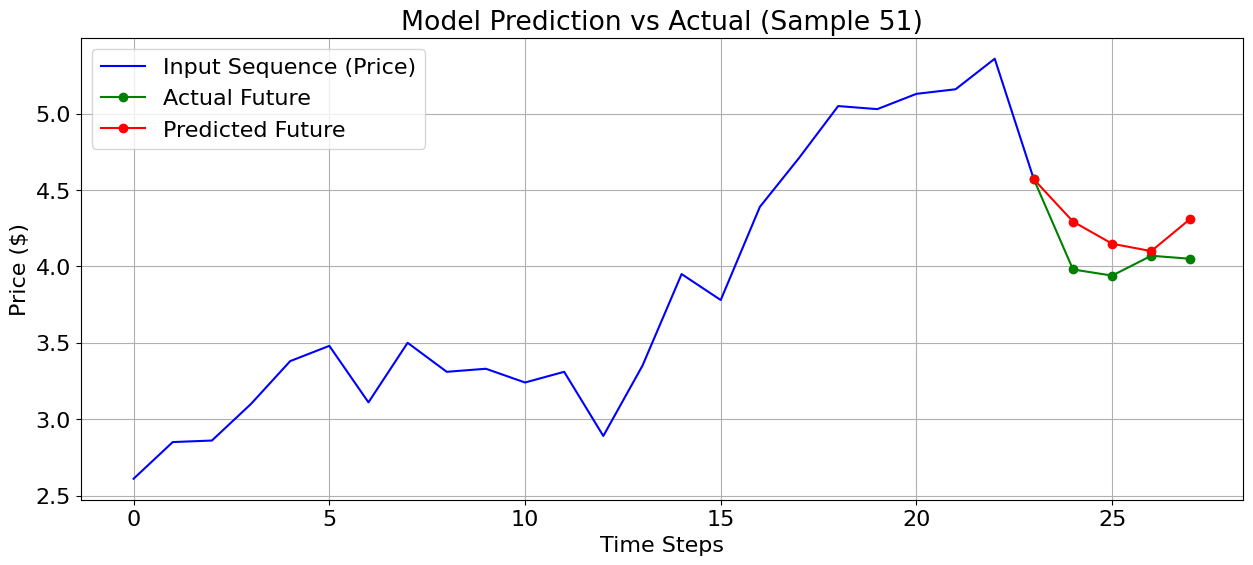


Numerical Comparison (Original Scale):
Actual values: [3.98 3.94 4.07 4.05]
Predicted values: [4.2937436 4.14851   4.100328  4.312161 ]
Mean Absolute Error: $0.20


In [ ]:
# Get a random sample from test set
sample_index = random.randrange(0, x_test.shape[0])
x_sample = x_test[sample_index]
y_actual = y_test[sample_index]

# Make prediction
y_pred = model.predict(x_sample[np.newaxis, :, :])

# Create and fit scaler with the original data range
scaler = MinMaxScaler(feature_range=(-1, 1))
# Fit scaler on the original price data (assuming price is the last feature)
scaler.fit(weather_corn_filled['PRICE'].values.reshape(-1, 1))

# Inverse transform predictions and actual values
y_pred_rescaled = scaler.inverse_transform(y_pred[0].reshape(-1, 1)).flatten()
y_actual_rescaled = scaler.inverse_transform(y_actual.reshape(-1, 1)).flatten()
x_sample_price_rescaled = scaler.inverse_transform(x_sample[:, -1].reshape(-1, 1)).flatten()

# Plot results
plt.figure(figsize=(15, 6))

# Plot input sequence
plt.plot(range(len(x_sample_price_rescaled)), x_sample_price_rescaled,
         label='Input Sequence (Price)', color='blue')

# Plot actual vs predicted values
plt.plot(range(len(x_sample_price_rescaled)-1, len(x_sample_price_rescaled) + len(y_actual_rescaled)),
         [x_sample_price_rescaled[-1]] + list(y_actual_rescaled),
         label='Actual Future', color='green', marker='o')
plt.plot(range(len(x_sample_price_rescaled)-1, len(x_sample_price_rescaled) + len(y_pred_rescaled)),
         [x_sample_price_rescaled[-1]] + list(y_pred_rescaled),
         label='Predicted Future', color='red', marker='o')

plt.title(f'Model Prediction vs Actual (Sample {sample_index})')
plt.xlabel('Time Steps')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

# Print numerical comparison
print("\nNumerical Comparison (Original Scale):")
print(f"Actual values: {y_actual_rescaled}")
print(f"Predicted values: {y_pred_rescaled}")
print(f"Mean Absolute Error: ${np.mean(np.abs(y_actual_rescaled - y_pred_rescaled)):.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  

Model Performance Metrics on Test Set:
Mean Squared Error (MSE): $0.03
Root Mean Squared Error (RMSE): $0.18
Mean Absolute Error (MAE): $0.13
Mean Absolute Percentage Error (MAPE): 3.28%
R-squared (R²): 0.9779
Directional Accuracy: 76.43%


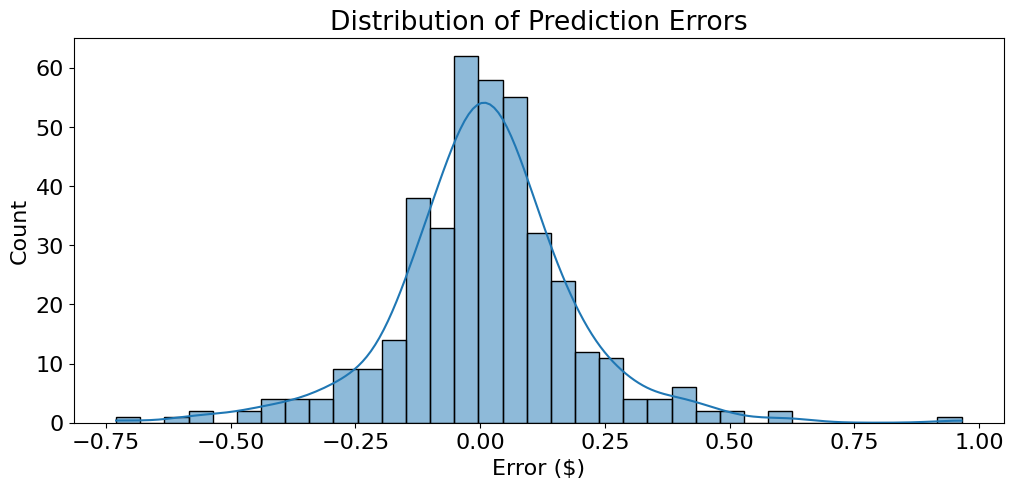

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Get predictions for entire test set
y_pred = model.predict(x_test)

# Create and fit scaler with the original data range
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(weather_corn_filled['PRICE'].values.reshape(-1, 1))

# Inverse transform predictions and actual values to original scale
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(y_test.shape)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)

# Calculate metrics
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

# Calculate MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_test_rescaled - y_pred_rescaled) / y_test_rescaled)) * 100

# Calculate directional accuracy
def directional_accuracy(y_true, y_pred):
    # Calculate directions (up/down) for true and predicted values
    true_direction = np.diff(y_true, axis=1) > 0
    pred_direction = np.diff(y_pred, axis=1) > 0

    # Compare directions and calculate accuracy
    correct_directions = np.equal(true_direction, pred_direction)
    return np.mean(correct_directions) * 100

da = directional_accuracy(y_test_rescaled, y_pred_rescaled)

print("\nModel Performance Metrics on Test Set:")
print(f"Mean Squared Error (MSE): ${mse:.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")
print(f"Mean Absolute Error (MAE): ${mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R-squared (R²): {r2:.4f}")
print(f"Directional Accuracy: {da:.2f}%")

# Optional: Plot distribution of errors
plt.figure(figsize=(12, 5))
errors = (y_test_rescaled - y_pred_rescaled).flatten()
sns.histplot(errors, kde=True)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error ($)')
plt.ylabel('Count')
plt.show()